In [1]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import train_test_split
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from flask import Flask, request, jsonify


import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import requests
import base64
import spotipy

In [3]:
client_id = '4e3582a2852e4d1dbc5631febb1c3f65'
client_secret = '8ff122559fb946288603a92f18a3af8d'

In [4]:
def get_access_token(client_id, client_secret):
    auth_url = "https://accounts.spotify.com/api/token"
    auth_header = {
        'Authorization' : f'Base{base64.b64encode((client_id + ":" + client_secret).encode()).decode()}'
    }
    auth_data = {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret
    }
    auth_responses = requests.post(auth_url, data = auth_data, headers = auth_header)
    auth_responses_data = auth_responses.json()
    access_token = auth_responses_data['access_token']
    return access_token

In [5]:
def get_access_token(client_id, client_secret):
    auth_url = "https://accounts.spotify.com/api/token"
    auth_header = {
        'Authorization': f'Basic {base64.b64encode((client_id + ":" + client_secret).encode()).decode()}'
    }
    auth_data = {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret
    }
    auth_response = requests.post(auth_url, data=auth_data, headers=auth_header)

    if auth_response.status_code == 200:
        auth_response_data = auth_response.json()
        if 'access_token' in auth_response_data:
            access_token = auth_response_data['access_token']
            return access_token
        else:
            print("Error: 'access_token' key not found in response:", auth_response_data)
    else:
        print("Error:", auth_response.status_code, auth_response.text)

    return None

In [6]:
def get_genrens(access_token, limit=50, offset=0):
    genres_url = 'https://api.spotify.com/v1/browse/categories'
    headers = {'Authorization': f'Bearer {access_token}'}
    params = {
        'limit': limit,
        'offset': offset
    }
    response = requests.get(genres_url, headers=headers, params=params)
    genres_data = response.json()
    genres = [(category['id'], category['name']) for category in genres_data['categories']['items']]
    return genres

In [7]:
client_id = '4e3582a2852e4d1dbc5631febb1c3f65'
client_secret = '8ff122559fb946288603a92f18a3af8d'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

access_token = get_access_token(client_id, client_secret)
def get_artist_genre(artist_id):
    artist = sp.artist(artist_id)
    return artist['genres']

In [8]:
def create_df(query_list, limit=50):
    data = {
        'Track ID': [],
        'Track name': [],
        'Artist name': [],
        'Popularity score': [],
        'Release year': [],
        'Genres': []
    }

    for query in query_list:
        search_results = sp.search(query, limit=limit, type='track')
        tracks = search_results['tracks']['items']

        for track in tracks:
            data['Track ID'].append(track['id'])
            data['Track name'].append(track['name'])
            data['Artist name'].append(track['artists'][0]['name'])
            data['Popularity score'].append(track['popularity'])
            data['Release year'].append(track['album']['release_date'][:4])
            data['Genres'].append(query)

        time.sleep(2)

    df = pd.DataFrame(data)
    return df


genres = ['genres:"Made For You"','genres:"Vietnamese Music"','genres:"Pop"','genres:"K-pop"','genres:"Hip-Hop"','genres:"Metal"',
         'genres:"Fresh Finds"','genres:"EQUAL"','genres:"GLOW"','genres:"RADAR"','genres:"Discover"','genres:"Jazz"',
         'genres:"Karaoke"','genres:"Mood"','genres:"Rock"','genres:"Latin"','genres:"Dance/Electronic"','genres:"Trending"',
         'genres:"Indie"','genres:"Workout"','genres:"Country"','genres:"R&B"','genres:"Chill"','genres:"Classical"',
         'genres:"Sleep"','genres:"Party"','genres:"At Home"','genres:"Decades"','genres:"Love"','genres:"Folk & Acoustic"',
         'genres:"Focus"','genres:"Soul"','genres:"Kids & Family"','genres:"Gaming"','genres:"Anime"','genres:"TV & Movies"','genres:"Disney"',
         'genres:"Netflix"','genres:"Instrumental"','genres:"Wellness"','genres:"Punk"','genres:"Ambient"','genres:"Blues"','genres:"Cooking & Dining"',
         'genres:"Alternative"','genres:"Travel"','genres:"Caribbean"','genres:"Afro"']
df = create_df(genres, limit=50)

In [9]:
print("List of genres: ")
for genre in genres:
    print(genre)


List of genres: 
genres:"Made For You"
genres:"Vietnamese Music"
genres:"Pop"
genres:"K-pop"
genres:"Hip-Hop"
genres:"Metal"
genres:"Fresh Finds"
genres:"EQUAL"
genres:"GLOW"
genres:"RADAR"
genres:"Discover"
genres:"Jazz"
genres:"Karaoke"
genres:"Mood"
genres:"Rock"
genres:"Latin"
genres:"Dance/Electronic"
genres:"Trending"
genres:"Indie"
genres:"Workout"
genres:"Country"
genres:"R&B"
genres:"Chill"
genres:"Classical"
genres:"Sleep"
genres:"Party"
genres:"At Home"
genres:"Decades"
genres:"Love"
genres:"Folk & Acoustic"
genres:"Focus"
genres:"Soul"
genres:"Kids & Family"
genres:"Gaming"
genres:"Anime"
genres:"TV & Movies"
genres:"Disney"
genres:"Netflix"
genres:"Instrumental"
genres:"Wellness"
genres:"Punk"
genres:"Ambient"
genres:"Blues"
genres:"Cooking & Dining"
genres:"Alternative"
genres:"Travel"
genres:"Caribbean"
genres:"Afro"


In [10]:
df

,Track ID,Track name,Artist name,Popularity score,Release year,Genres
0,5L46iplwQ3mv5KJhuJDiLk,Made For Me - Cover,renewwed,11,2024,"genres:""Made For You"""
1,3YJhM5Kq7lI7GN9XeWISXS,Made for You,Cepi Valentino,1,2019,"genres:""Made For You"""
2,4l5u4V4zMqJD18qO4CLnkR,Vietnamese Coffee,HLY WUD,39,2023,"genres:""Vietnamese Music"""
3,29WKuuQ05boAUWWGve5xXy,Vietnamese,HeeTee,12,2020,"genres:""Vietnamese Music"""
4,41I4mkrKN0H73COxjhNrPp,Vietnamese Music,Musics For everyday,3,2022,"genres:""Vietnamese Music"""
...,...,...,...,...,...,...
1781,18Zos8ul5UrhxDtbeJ0Epc,Creations,Afro Lofi Guy,26,2024,"genres:""Afro"""
1782,6ojCyF3WxvNw3Ncd7jD19u,H. Birthday To Regina - Afro Pop,Happy Birthday All Names & Genres,0,1912,"genres:""Afro"""
1783,5jJqg5lrh7Ve9iirQyH6UC,Afro Ragga,TMX Official,33,2022,"genres:""Afro"""
1784,1VaeWVaRT1ytTWLVRwGZNx,Happy Birthday To You - Afro Pop,Happy Birthday All Names & Genres,0,1893,"genres:""Afro"""


In [11]:
def get_audio_features(track_ids):
    features_list = []
    for i in range(0, len(track_ids), 50):
        batch = track_ids[i:i + 50]
        features_results = sp.audio_features(batch)
        features_list.extend([f for f in features_results if f is not None])
    return features_list

In [12]:
track_ids = df['Track ID'].tolist()
audio_features = get_audio_features(track_ids)

audio_features_df = pd.DataFrame(audio_features)
merged_df = df.merge(audio_features_df, left_on='Track ID', right_on='id', how='inner')

In [13]:
merged_df

,Track ID,Track name,Artist name,Popularity score,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,5L46iplwQ3mv5KJhuJDiLk,Made For Me - Cover,renewwed,11,2024,"genres:""Made For You""",0.779,0.479,7,-6.285,...,0.0913,0.101,119.973,audio_features,5L46iplwQ3mv5KJhuJDiLk,spotify:track:5L46iplwQ3mv5KJhuJDiLk,https://api.spotify.com/v1/tracks/5L46iplwQ3mv...,https://api.spotify.com/v1/audio-analysis/5L46...,186096,4
1,3YJhM5Kq7lI7GN9XeWISXS,Made for You,Cepi Valentino,1,2019,"genres:""Made For You""",0.657,0.383,2,-11.416,...,0.4940,0.224,104.038,audio_features,3YJhM5Kq7lI7GN9XeWISXS,spotify:track:3YJhM5Kq7lI7GN9XeWISXS,https://api.spotify.com/v1/tracks/3YJhM5Kq7lI7...,https://api.spotify.com/v1/audio-analysis/3YJh...,207692,4
2,4l5u4V4zMqJD18qO4CLnkR,Vietnamese Coffee,HLY WUD,39,2023,"genres:""Vietnamese Music""",0.568,0.151,8,-18.405,...,0.3590,0.039,110.125,audio_features,4l5u4V4zMqJD18qO4CLnkR,spotify:track:4l5u4V4zMqJD18qO4CLnkR,https://api.spotify.com/v1/tracks/4l5u4V4zMqJD...,https://api.spotify.com/v1/audio-analysis/4l5u...,146182,4
3,29WKuuQ05boAUWWGve5xXy,Vietnamese,HeeTee,12,2020,"genres:""Vietnamese Music""",0.895,0.678,1,-7.693,...,0.1470,0.584,150.000,audio_features,29WKuuQ05boAUWWGve5xXy,spotify:track:29WKuuQ05boAUWWGve5xXy,https://api.spotify.com/v1/tracks/29WKuuQ05boA...,https://api.spotify.com/v1/audio-analysis/29WK...,142000,4
4,41I4mkrKN0H73COxjhNrPp,Vietnamese Music,Musics For everyday,3,2022,"genres:""Vietnamese Music""",0.370,0.271,4,-13.439,...,0.0860,0.199,99.848,audio_features,41I4mkrKN0H73COxjhNrPp,spotify:track:41I4mkrKN0H73COxjhNrPp,https://api.spotify.com/v1/tracks/41I4mkrKN0H7...,https://api.spotify.com/v1/audio-analysis/41I4...,283824,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892,18Zos8ul5UrhxDtbeJ0Epc,Creations,Afro Lofi Guy,26,2024,"genres:""Afro""",0.572,0.536,4,-13.614,...,0.1110,0.159,89.979,audio_features,18Zos8ul5UrhxDtbeJ0Epc,spotify:track:18Zos8ul5UrhxDtbeJ0Epc,https://api.spotify.com/v1/tracks/18Zos8ul5Urh...,https://api.spotify.com/v1/audio-analysis/18Zo...,97333,4
1893,6ojCyF3WxvNw3Ncd7jD19u,H. Birthday To Regina - Afro Pop,Happy Birthday All Names & Genres,0,1912,"genres:""Afro""",0.834,0.289,5,-12.227,...,0.0863,0.525,107.973,audio_features,6ojCyF3WxvNw3Ncd7jD19u,spotify:track:6ojCyF3WxvNw3Ncd7jD19u,https://api.spotify.com/v1/tracks/6ojCyF3WxvNw...,https://api.spotify.com/v1/audio-analysis/6ojC...,30999,3
1894,5jJqg5lrh7Ve9iirQyH6UC,Afro Ragga,TMX Official,33,2022,"genres:""Afro""",0.880,0.759,11,-5.987,...,0.0847,0.222,100.016,audio_features,5jJqg5lrh7Ve9iirQyH6UC,spotify:track:5jJqg5lrh7Ve9iirQyH6UC,https://api.spotify.com/v1/tracks/5jJqg5lrh7Ve...,https://api.spotify.com/v1/audio-analysis/5jJq...,130531,4
1895,1VaeWVaRT1ytTWLVRwGZNx,Happy Birthday To You - Afro Pop,Happy Birthday All Names & Genres,0,1893,"genres:""Afro""",0.844,0.275,5,-12.051,...,0.0874,0.430,107.939,audio_features,1VaeWVaRT1ytTWLVRwGZNx,spotify:track:1VaeWVaRT1ytTWLVRwGZNx,https://api.spotify.com/v1/tracks/1VaeWVaRT1yt...,https://api.spotify.com/v1/audio-analysis/1Vae...,30999,3


In [14]:
unique_df = merged_df.drop_duplicates(subset='Track ID', keep='first')
unique_df

,Track ID,Track name,Artist name,Popularity score,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,5L46iplwQ3mv5KJhuJDiLk,Made For Me - Cover,renewwed,11,2024,"genres:""Made For You""",0.779,0.479,7,-6.285,...,0.0913,0.101,119.973,audio_features,5L46iplwQ3mv5KJhuJDiLk,spotify:track:5L46iplwQ3mv5KJhuJDiLk,https://api.spotify.com/v1/tracks/5L46iplwQ3mv...,https://api.spotify.com/v1/audio-analysis/5L46...,186096,4
1,3YJhM5Kq7lI7GN9XeWISXS,Made for You,Cepi Valentino,1,2019,"genres:""Made For You""",0.657,0.383,2,-11.416,...,0.4940,0.224,104.038,audio_features,3YJhM5Kq7lI7GN9XeWISXS,spotify:track:3YJhM5Kq7lI7GN9XeWISXS,https://api.spotify.com/v1/tracks/3YJhM5Kq7lI7...,https://api.spotify.com/v1/audio-analysis/3YJh...,207692,4
2,4l5u4V4zMqJD18qO4CLnkR,Vietnamese Coffee,HLY WUD,39,2023,"genres:""Vietnamese Music""",0.568,0.151,8,-18.405,...,0.3590,0.039,110.125,audio_features,4l5u4V4zMqJD18qO4CLnkR,spotify:track:4l5u4V4zMqJD18qO4CLnkR,https://api.spotify.com/v1/tracks/4l5u4V4zMqJD...,https://api.spotify.com/v1/audio-analysis/4l5u...,146182,4
3,29WKuuQ05boAUWWGve5xXy,Vietnamese,HeeTee,12,2020,"genres:""Vietnamese Music""",0.895,0.678,1,-7.693,...,0.1470,0.584,150.000,audio_features,29WKuuQ05boAUWWGve5xXy,spotify:track:29WKuuQ05boAUWWGve5xXy,https://api.spotify.com/v1/tracks/29WKuuQ05boA...,https://api.spotify.com/v1/audio-analysis/29WK...,142000,4
4,41I4mkrKN0H73COxjhNrPp,Vietnamese Music,Musics For everyday,3,2022,"genres:""Vietnamese Music""",0.370,0.271,4,-13.439,...,0.0860,0.199,99.848,audio_features,41I4mkrKN0H73COxjhNrPp,spotify:track:41I4mkrKN0H73COxjhNrPp,https://api.spotify.com/v1/tracks/41I4mkrKN0H7...,https://api.spotify.com/v1/audio-analysis/41I4...,283824,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892,18Zos8ul5UrhxDtbeJ0Epc,Creations,Afro Lofi Guy,26,2024,"genres:""Afro""",0.572,0.536,4,-13.614,...,0.1110,0.159,89.979,audio_features,18Zos8ul5UrhxDtbeJ0Epc,spotify:track:18Zos8ul5UrhxDtbeJ0Epc,https://api.spotify.com/v1/tracks/18Zos8ul5Urh...,https://api.spotify.com/v1/audio-analysis/18Zo...,97333,4
1893,6ojCyF3WxvNw3Ncd7jD19u,H. Birthday To Regina - Afro Pop,Happy Birthday All Names & Genres,0,1912,"genres:""Afro""",0.834,0.289,5,-12.227,...,0.0863,0.525,107.973,audio_features,6ojCyF3WxvNw3Ncd7jD19u,spotify:track:6ojCyF3WxvNw3Ncd7jD19u,https://api.spotify.com/v1/tracks/6ojCyF3WxvNw...,https://api.spotify.com/v1/audio-analysis/6ojC...,30999,3
1894,5jJqg5lrh7Ve9iirQyH6UC,Afro Ragga,TMX Official,33,2022,"genres:""Afro""",0.880,0.759,11,-5.987,...,0.0847,0.222,100.016,audio_features,5jJqg5lrh7Ve9iirQyH6UC,spotify:track:5jJqg5lrh7Ve9iirQyH6UC,https://api.spotify.com/v1/tracks/5jJqg5lrh7Ve...,https://api.spotify.com/v1/audio-analysis/5jJq...,130531,4
1895,1VaeWVaRT1ytTWLVRwGZNx,Happy Birthday To You - Afro Pop,Happy Birthday All Names & Genres,0,1893,"genres:""Afro""",0.844,0.275,5,-12.051,...,0.0874,0.430,107.939,audio_features,1VaeWVaRT1ytTWLVRwGZNx,spotify:track:1VaeWVaRT1ytTWLVRwGZNx,https://api.spotify.com/v1/tracks/1VaeWVaRT1yt...,https://api.spotify.com/v1/audio-analysis/1Vae...,30999,3


In [15]:
print(unique_df.columns)

Index(['Track ID', 'Track name', 'Artist name', 'Popularity score',
       'Release year', 'Genres', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')


In [16]:
len(unique_df)

1717

In [17]:
filtered_df = unique_df[unique_df['Popularity score']>0]
filtered_df = filtered_df.sort_values(by='Popularity score', ascending=False)
filtered_df

,Track ID,Track name,Artist name,Popularity score,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
153,1SS0WlKhJewviwEDZ6dWj0,SPOT!,ZICO,87,2024,"genres:""K-pop""",0.875,0.782,5,-3.905,...,0.1130,0.906,108.038,audio_features,1SS0WlKhJewviwEDZ6dWj0,spotify:track:1SS0WlKhJewviwEDZ6dWj0,https://api.spotify.com/v1/tracks/1SS0WlKhJewv...,https://api.spotify.com/v1/audio-analysis/1SS0...,167707,4
157,4gOwpU4kMZZNDWkoHYUj1Z,해야 (HEYA),IVE,80,2024,"genres:""K-pop""",0.702,0.837,5,-3.447,...,0.2270,0.685,91.986,audio_features,4gOwpU4kMZZNDWkoHYUj1Z,spotify:track:4gOwpU4kMZZNDWkoHYUj1Z,https://api.spotify.com/v1/tracks/4gOwpU4kMZZN...,https://api.spotify.com/v1/audio-analysis/4gOw...,189680,4
155,6rdkCkjk6D12xRpdMXy0I2,New Jeans,NewJeans,79,2023,"genres:""K-pop""",0.807,0.721,4,-6.211,...,0.1150,0.532,134.014,audio_features,6rdkCkjk6D12xRpdMXy0I2,spotify:track:6rdkCkjk6D12xRpdMXy0I2,https://api.spotify.com/v1/tracks/6rdkCkjk6D12...,https://api.spotify.com/v1/audio-analysis/6rdk...,108987,4
165,4uOBL4DDWWVx4RhYKlPbPC,Queencard,(G)I-DLE,77,2023,"genres:""K-pop""",0.815,0.834,4,-2.828,...,0.2700,0.692,129.989,audio_features,4uOBL4DDWWVx4RhYKlPbPC,spotify:track:4uOBL4DDWWVx4RhYKlPbPC,https://api.spotify.com/v1/tracks/4uOBL4DDWWVx...,https://api.spotify.com/v1/audio-analysis/4uOB...,161240,4
163,3gTQwwDNJ42CCLo3Sf4JDd,S-Class,Stray Kids,75,2023,"genres:""K-pop""",0.886,0.781,5,-1.837,...,0.0715,0.672,104.996,audio_features,3gTQwwDNJ42CCLo3Sf4JDd,spotify:track:3gTQwwDNJ42CCLo3Sf4JDd,https://api.spotify.com/v1/tracks/3gTQwwDNJ42C...,https://api.spotify.com/v1/audio-analysis/3gTQ...,195689,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,4w4n88Wa11zvlF6kdpiC3W,All I Need,Shinichi Osawa,1,2014,"genres:""Hip-Hop""",0.767,0.693,8,-7.574,...,0.1070,0.286,119.002,audio_features,4w4n88Wa11zvlF6kdpiC3W,spotify:track:4w4n88Wa11zvlF6kdpiC3W,https://api.spotify.com/v1/tracks/4w4n88Wa11zv...,https://api.spotify.com/v1/audio-analysis/4w4n...,331468,4
218,2Z6jfM2jEPJ2JU09XeGmnV,Happy Birthday To Ryker - Hip Hop,Happy Birthday All Names & Genres,1,1912,"genres:""Hip-Hop""",0.755,0.703,5,-11.286,...,0.0855,0.696,107.944,audio_features,2Z6jfM2jEPJ2JU09XeGmnV,spotify:track:2Z6jfM2jEPJ2JU09XeGmnV,https://api.spotify.com/v1/tracks/2Z6jfM2jEPJ2...,https://api.spotify.com/v1/audio-analysis/2Z6j...,30999,3
226,6K1NQ3yxuN4Pfmjpxeo76v,Summer in 82,SUPERBEE,1,2017,"genres:""Hip-Hop""",0.750,0.840,1,-2.050,...,0.3180,0.701,105.056,audio_features,6K1NQ3yxuN4Pfmjpxeo76v,spotify:track:6K1NQ3yxuN4Pfmjpxeo76v,https://api.spotify.com/v1/tracks/6K1NQ3yxuN4P...,https://api.spotify.com/v1/audio-analysis/6K1N...,169649,4
440,0VyKWCxp1hKoXceMCLebd0,GLOW,Topp,1,2020,"genres:""GLOW""",0.349,0.454,5,-10.650,...,0.2080,0.213,124.211,audio_features,0VyKWCxp1hKoXceMCLebd0,spotify:track:0VyKWCxp1hKoXceMCLebd0,https://api.spotify.com/v1/tracks/0VyKWCxp1hKo...,https://api.spotify.com/v1/audio-analysis/0VyK...,176608,4


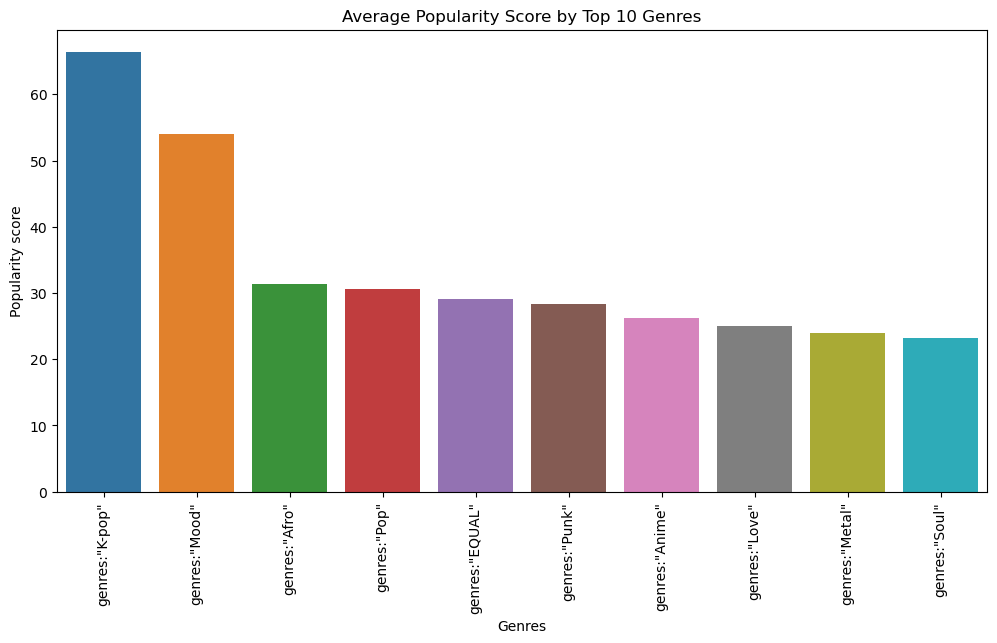

In [18]:
genre_popularity = filtered_df.groupby('Genres')['Popularity score'].mean().reset_index()
genre_popularity = genre_popularity.sort_values('Popularity score', ascending=False)

genre_popularity = genre_popularity.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Genres', y='Popularity score', data= genre_popularity)
plt.xticks(rotation=90)
plt.title('Average Popularity Score by Top 10 Genres')
plt.show()

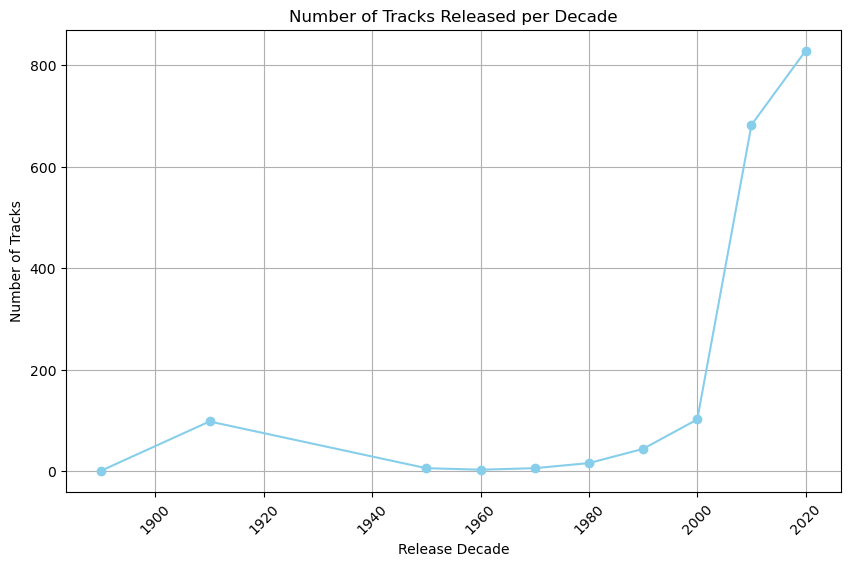

In [19]:
# Assuming your DataFrame is named df
# Convert 'Release year' column to numeric type
df['Release year'] = pd.to_numeric(df['Release year'], errors='coerce')

# Drop rows with NaN values in 'Release year' column
df = df.dropna(subset=['Release year'])

# Group the data by 10-year intervals of release years and count the number of tracks in each interval
tracks_per_decade = df.groupby((df['Release year'] // 10) * 10).size()

# Create a line plot
plt.figure(figsize=(10, 6))
tracks_per_decade.plot(kind='line', marker='o', color='skyblue', linestyle='-')
plt.title('Number of Tracks Released per Decade')
plt.xlabel('Release Decade')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

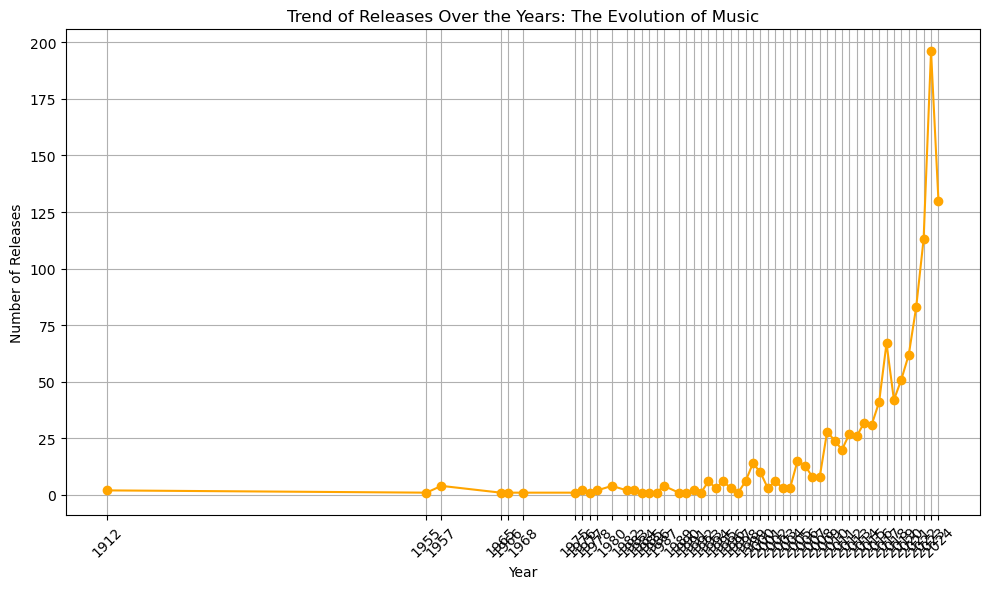

In [20]:
# Assuming filtered_df contains the necessary data

# Convert release year to datetime
filtered_df['Release year'] = pd.to_datetime(filtered_df['Release year'], format='%Y')

# Group by release year and count the number of releases
release_trend = filtered_df.groupby(filtered_df['Release year'].dt.year).size()

plt.figure(figsize=(10, 6))
plt.plot(release_trend.index, release_trend.values, marker='o', color='orange')
plt.title('Trend of Releases Over the Years: The Evolution of Music')
plt.xlabel('Year')
plt.ylabel('Number of Releases')
plt.grid(True)
plt.xticks(release_trend.index, rotation=45)
plt.tight_layout()
plt.show()


In [21]:
columns_to_drop = ['Track ID', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature']
filtered_df = filtered_df.drop(columns=columns_to_drop)

print(filtered_df.head())

    Track name Artist name  Popularity score Release year          Genres  \
153      SPOT!        ZICO                87   2024-01-01  genres:"K-pop"   
157  해야 (HEYA)         IVE                80   2024-01-01  genres:"K-pop"   
155  New Jeans    NewJeans                79   2023-01-01  genres:"K-pop"   
165  Queencard    (G)I-DLE                77   2023-01-01  genres:"K-pop"   
163    S-Class  Stray Kids                75   2023-01-01  genres:"K-pop"   

     danceability  energy  key  loudness  mode  speechiness  acousticness  \
153         0.875   0.782    5    -3.905     0       0.0780        0.1510   
157         0.702   0.837    5    -3.447     0       0.0567        0.0297   
155         0.807   0.721    4    -6.211     0       0.0508        0.5100   
165         0.815   0.834    4    -2.828     0       0.0475        0.0327   
163         0.886   0.781    5    -1.837     0       0.3330        0.0895   

     instrumentalness  liveness  valence    tempo  
153          0.000000 

In [22]:
bins = [0, 49, 69, 100]
labels = ['Low', 'Medium', 'High']

filtered_df['Popularity Category'] = pd.cut(filtered_df['Popularity score'], bins= bins, labels=labels)
print(filtered_df)

                            Track name                        Artist name  \
153                              SPOT!                               ZICO   
157                          해야 (HEYA)                                IVE   
155                          New Jeans                           NewJeans   
165                          Queencard                           (G)I-DLE   
163                            S-Class                         Stray Kids   
..                                 ...                                ...   
217                         All I Need                     Shinichi Osawa   
218  Happy Birthday To Ryker - Hip Hop  Happy Birthday All Names & Genres   
226                       Summer in 82                           SUPERBEE   
440                               GLOW                               Topp   
723             Electronic Dance Music             Chill Every Night Club   

     Popularity score Release year                     Genres  danceability

In [23]:
high_popularity_df = filtered_df[filtered_df['Popularity Category'] == 'High']
medium_popularity_df = filtered_df[filtered_df['Popularity Category'] == 'Medium']
low_popularity_df = filtered_df[filtered_df['Popularity Category'] == 'Low']

In [24]:
print(high_popularity_df.head())

    Track name Artist name  Popularity score Release year          Genres  \
153      SPOT!        ZICO                87   2024-01-01  genres:"K-pop"   
157  해야 (HEYA)         IVE                80   2024-01-01  genres:"K-pop"   
155  New Jeans    NewJeans                79   2023-01-01  genres:"K-pop"   
165  Queencard    (G)I-DLE                77   2023-01-01  genres:"K-pop"   
163    S-Class  Stray Kids                75   2023-01-01  genres:"K-pop"   

     danceability  energy  key  loudness  mode  speechiness  acousticness  \
153         0.875   0.782    5    -3.905     0       0.0780        0.1510   
157         0.702   0.837    5    -3.447     0       0.0567        0.0297   
155         0.807   0.721    4    -6.211     0       0.0508        0.5100   
165         0.815   0.834    4    -2.828     0       0.0475        0.0327   
163         0.886   0.781    5    -1.837     0       0.3330        0.0895   

     instrumentalness  liveness  valence    tempo Popularity Category  
15

In [25]:
print(medium_popularity_df.head())

            Track name          Artist name  Popularity score Release year  \
175             Scream              ENHYPEN                69   2024-01-01   
177  Good Boy Gone Bad  TOMORROW X TOGETHER                69   2022-01-01   
173         Red Flavor           Red Velvet                68   2017-01-01   
187                O.O                NMIXX                67   2022-01-01   
181                Gee    Girls' Generation                66   2010-01-01   

             Genres  danceability  energy  key  loudness  mode  speechiness  \
175  genres:"K-pop"         0.679   0.877   11    -2.777     0       0.0561   
177  genres:"K-pop"         0.475   0.695    1    -5.919     1       0.1020   
173  genres:"K-pop"         0.709   0.917    9    -3.315     1       0.1890   
187  genres:"K-pop"         0.389   0.770   11    -3.920     0       0.2970   
181  genres:"K-pop"         0.756   0.930    1    -1.082     0       0.0274   

     acousticness  instrumentalness  liveness  valence  

In [26]:
print(low_popularity_df.head())

                     Track name              Artist name  Popularity score  \
1885    Afro Trap Pt. 8 (Never)                      MHD                49   
388   The Equaliser (Not Alone)             The Midnight                49   
392              = (Equal Sign)                   j-hope                48   
1807             Caribbean Rave                      W&W                48   
1410    Un Monde Qui S'Illumine  Cast – Disneyland Paris                48   

     Release year              Genres  danceability  energy  key  loudness  \
1885   2017-01-01       genres:"Afro"         0.925   0.865    1    -4.718   
388    2016-01-01      genres:"EQUAL"         0.543   0.653    2    -7.223   
392    2023-01-01      genres:"EQUAL"         0.673   0.750    9    -5.831   
1807   2016-01-01  genres:"Caribbean"         0.603   0.903    4    -1.539   
1410   2022-01-01     genres:"Disney"         0.736   0.659    1    -6.433   

      mode  speechiness  acousticness  instrumentalness  liven

In [27]:
filtered_df.columns

Index(['Track name', 'Artist name', 'Popularity score', 'Release year',
       'Genres', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'Popularity Category'],
      dtype='object')

In [28]:
# Preprocess the data
categorical_cols = ['Track name', 'Artist name', 'Genres']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_cols)])

X = preprocessor.fit_transform(filtered_df.drop('Popularity Category', axis=1))

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_df['Popularity Category'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBClassifier
xgb_clf = XGBClassifier(random_state=1000)
xgb_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

# Get feature importances
importances = xgb_clf.feature_importances_

feature_names = preprocessor.transformers_[0][1].get_feature_names_out()

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({"feature": feature_names, "importance": importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Print the top features
print("\nTop features:")
print(feature_importances.head())

Accuracy: 0.9821428571428571
Precision: 0.5302891933028919
Recall: 0.5318042813455658
F1-score: 0.5310450038138824

Top features:
                            feature  importance
1689          Genres_genres:"K-pop"    0.787605
1451  Artist name_Punk Rock Factory    0.073631
317                Track name_Equal    0.051723
119              Track name_At Home    0.022560
1147    Artist name_EquallyOpposite    0.020405


c:\Users\maito\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Preprocess the data
categorical_cols = ['Track name', 'Artist name', 'Popularity score', 'Release year',
       'Genres','danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_cols)])

X = preprocessor.fit_transform(filtered_df.drop('Popularity Category', axis=1))

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_df['Popularity Category'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBClassifier
xgb_clf = XGBClassifier(max_depth = 3,
                        subsample = 0.7,
                        colsample_bytree = 0.8,
                        random_state=50)
xgb_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

# Get feature importances
importances = xgb_clf.feature_importances_

# Get the feature names
feature_names = [f.split("_")[0] for f in preprocessor.transformers_[0][1].get_feature_names_out(categorical_cols)]

# Aggregate importances by feature name
import numpy as np
aggregated_importances = {}
for feature_name, importance in zip(feature_names, importances):
    if feature_name in aggregated_importances:
        aggregated_importances[feature_name] += importance
    else:
        aggregated_importances[feature_name] = importance

# Print the aggregated feature importances sorted by importance
sorted_importances = sorted(aggregated_importances.items(), key=lambda x: x[1], reverse=True)
print("\nFeature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.3f}")

Accuracy: 0.9866071428571429
Precision: 0.9136225266362253
Recall: 0.8651376146788992
F1-score: 0.886600559369438

Feature Importances:
Popularity score: 0.301
Genres: 0.149
danceability: 0.116
Release year: 0.091
liveness: 0.073
key: 0.070
valence: 0.050
Artist name: 0.047
speechiness: 0.043
acousticness: 0.027
Track name: 0.014
mode: 0.012
instrumentalness: 0.007
energy: 0.000
loudness: 0.000
tempo: 0.000


In [30]:
# Save the model
pickle.dump(xgb_clf, open("xgb_model.pkl", "wb"))

# Save the preprocessor and label encoder
pickle.dump(preprocessor, open("preprocessor.pkl", "wb"))
pickle.dump(label_encoder, open("label_encoder.pkl", "wb"))


In [31]:
# def extract_features(data):
#   features = {}

#   # Track Name Features
#   features['track_name_length'] = len(data['Track name'])
#   keywords = ['love', 'dance', 'party']  # Example keywords
#   features['keyword_count'] = sum(keyword in data['Track name'] for keyword in keywords)
#   features['word_count'] = len(data['Track name'].split())

#   # Artist Name Features (assuming you have artist popularity data)
#   features['artist_popularity'] = data['artist_popularity']  # Replace with actual data

#   # Audio Features
#   features.update(data[['danceability', 'energy', 'key', 'loudness', 'mode',
#                         'speechiness', 'acousticness', 'instrumentalness',
#                         'liveness', 'valence', 'tempo']].to_dict('list')[0])  # Assuming data is a dictionary

#   # Popularity Score
#   features['popularity_score'] = data['Popularity score']
#   # ... (Optional: Logarithmic transformation or other modifications)

#   # Genre-Specific Features (assuming you have genre data)
#   # ... (Calculate deviations from genre averages for audio features)

#   # Lyrical Analysis Features (if feasible)
#   # ... (Perform sentiment analysis or topic modeling)

#   return features